# Import water level df

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_csv('/home/song/Public/Song/Work/Thesis/data/water.csv',index_col=['date_time'],parse_dates=['date_time'])
df.head()

,BKK001,BKK002,BKK003,BKK004,BKK005,BKK006,BKK007,BKK008,BKK009,BKK012,...,YOM003,YOM004,YOM005,YOM006,YOM007,YOM008,YOM009,YOM010,YOM011,YOM012
date_time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


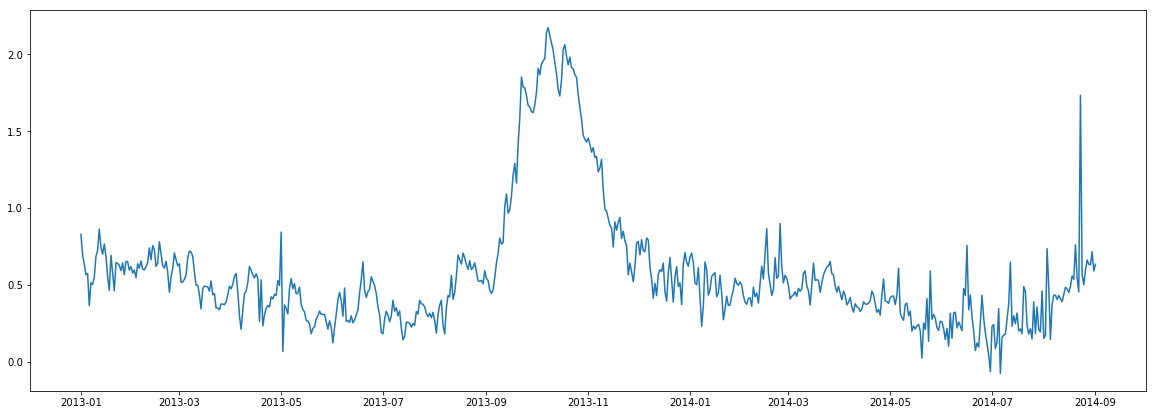

"\nfig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)\nfor name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):\nsns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)\nax.set_ylabel('GWh')\nax.set_title(name)\n# Remove the automatic x-axis label from all but the bottom subplot\nif ax != axes[-1]:\n    ax.set_xlabel('')\n"

In [3]:
bkkwater = df['CPY014']["2013-01-01":"2014-09-01"]
bkkwater = bkkwater.resample('d').mean()
#bkkwater = water['CPY014']["2013-01-01":"2014-09-01"]
fig,ax = plt.subplots(figsize=(20,7))
sns.lineplot(data=bkkwater,ax=ax)
plt.show()

"""
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):
sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
ax.set_ylabel('GWh')
ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')
"""

In [4]:
bkkwater.shape

(609,)

# ARIMA Analysis

In [5]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf

In [6]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    
    print(df_results)
    
    #extra
    if df_results[1] <= 0.05:
        print("strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a  unit root, indicating it is non-stationary")
        
test_stationarity(bkkwater.dropna())

Test Statistic           -3.046959
p-value                   0.030736
Lags                     19.000000
Observations            587.000000
Critical Value (1%)      -3.441539
Critical Value (5%)      -2.866476
Critical Value (10%)     -2.569399
dtype: float64
strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary


In [7]:
#CHECK NULL VALUE

#bkkwater = df['CPY014']["2012-08-01":"2017-10-01"]
y = bkkwater.interpolate(method='pad', limit=100).dropna()
#y.plot()
X = y.values
np.isnan(X.sum())

False

In [8]:
size = int(len(X) * 0.66)
train, test = X[0:size-1], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,1)) #edited pdq already
	model_fit = model.fit()             ###
	output = model_fit.forecast()       ###
	yhat = output[0]
	predictions.append(yhat)            ###
	obs = test[t]
	history.append(obs)
	#print(t,'....predicted=%f, expected=%f' % (yhat, obs))

Test MSE: 0.026


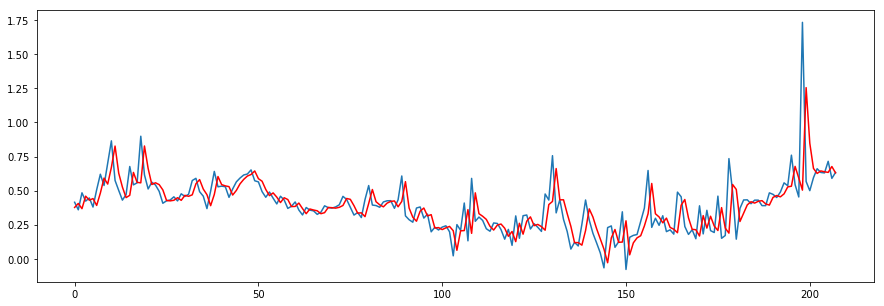

In [9]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize=(15,5))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

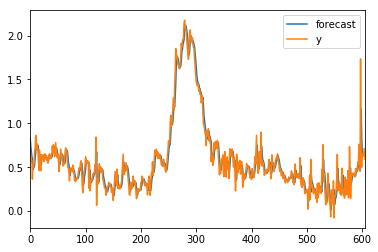

In [10]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [11]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  606
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 414.105
Method:                       css-mle   S.D. of innovations              0.122
Date:                Wed, 21 Oct 2020   AIC                           -822.210
Time:                        12:57:53   BIC                           -808.989
Sample:                             1   HQIC                          -817.065
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.070      0.944      -0.005       0.005
ma.L1.D.y     -0.4695      0.038    -12.383      0.000      -0.544      -0.395
                                    Roots           

In [12]:
"""fig = plt.figure(figsize=(20,8))
x = model_fit.predict(start=(100), end=(120), dynamic=False)

plt.plot(y[:100])
plt.plot(x, color='r')"""

"fig = plt.figure(figsize=(20,8))\nx = model_fit.predict(start=(100), end=(120), dynamic=False)\n\nplt.plot(y[:100])\nplt.plot(x, color='r')"

* Find best parameter

In [13]:
"""# Best Parameter
import itertools
import warnings
#p=d=q=range(0,10)
#pdq = list(itertools.product(p,d,q))

p=q=range(0,10)
d=range(1,4) # fix d = 1 or 2
pdq = itertools.product(p,d,q)

aic_result =999999
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train,order=param)
        model_arima_fit = model_arima.fit()
        if model_arima_fit.aic < aic_result:
            aic_result = model_arima_fit.aic
            print(param,model_arima_fit.aic)
    except:
        continue"""

"# Best Parameter\nimport itertools\nimport warnings\n#p=d=q=range(0,10)\n#pdq = list(itertools.product(p,d,q))\n\np=q=range(0,10)\nd=range(1,4) # fix d = 1 or 2\npdq = itertools.product(p,d,q)\n\naic_result =999999\nwarnings.filterwarnings('ignore')\nfor param in pdq:\n    try:\n        model_arima = ARIMA(train,order=param)\n        model_arima_fit = model_arima.fit()\n        if model_arima_fit.aic < aic_result:\n            aic_result = model_arima_fit.aic\n            print(param,model_arima_fit.aic)\n    except:\n        continue"

# WA_ANN

In [30]:
import pywt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense

In [40]:
lv = int(np.log(len(X)))
coeffs = pywt.wavedec(X, 'db1', level=lv)


In [55]:
#https://www.kaggle.com/theoviel/denoising-with-direct-wavelet-transform

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


610 609


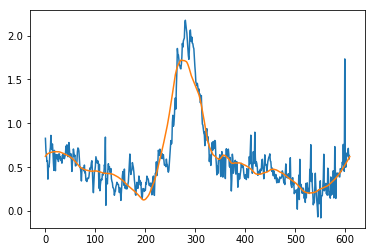

In [88]:
wa_X = wavelet_denoising(X,level=lv)
print(len(wa_X),len(X))
plt.plot(X)
plt.plot(wa_X)

In [64]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_sc = wa_X.reshape(-1,1)
X_sc = scaler.fit_transform(X_sc)
size = int(len(X_sc) * 0.66)
train, test = X_sc[0:size-1], X_sc[size:len(X)]

In [65]:
X_train = train[:-1]
y_train = train[1:]
X_test = test[:-1]
y_test = test[1:]

In [92]:
model = Sequential()
model.add(Dense(12, input_dim=1,activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


In [93]:
EPOCH = 70
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=10, verbose=1,shuffle=False)

Epoch 1/70
400/400 [==============================] - 0s 276us/step - loss: 0.8875
Epoch 2/70
400/400 [==============================] - 0s 126us/step - loss: 0.8175
Epoch 3/70
400/400 [==============================] - 0s 131us/step - loss: 0.7391
Epoch 4/70
400/400 [==============================] - 0s 136us/step - loss: 0.6406
Epoch 5/70
400/400 [==============================] - 0s 154us/step - loss: 0.5457
Epoch 6/70
400/400 [==============================] - 0s 154us/step - loss: 0.4660
Epoch 7/70
400/400 [==============================] - 0s 121us/step - loss: 0.4073
Epoch 8/70
400/400 [==============================] - 0s 117us/step - loss: 0.3674
Epoch 9/70
400/400 [==============================] - 0s 123us/step - loss: 0.3409
Epoch 10/70
400/400 [==============================] - 0s 122us/step - loss: 0.3227
Epoch 11/70
400/400 [==============================] - 0s 116us/step - loss: 0.3097
Epoch 12/70
400/400 [==============================] - 0s 118us/step - loss: 0.2999
E

In [100]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

error = mean_squared_error(X_test, y_pred_test)
print('Test MSE: %.3f' % error)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_pred_train)))
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))

Test MSE: 0.496
The R2 score on the Train set is:	0.008
The R2 score on the Train set is:	-28.267


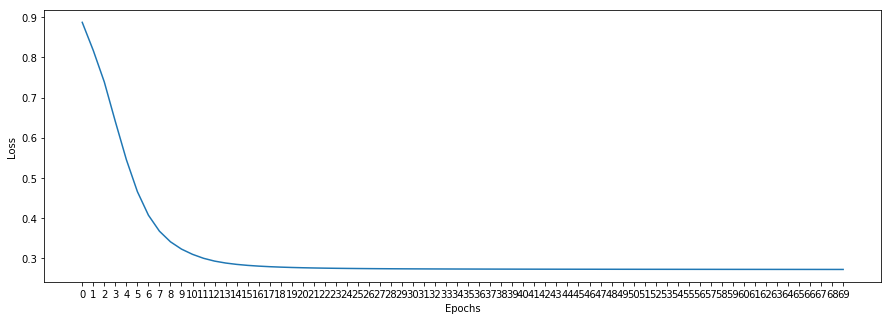

In [95]:
loss_ann = model.history.history['loss']
plt.figure(figsize=(15,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,EPOCH,1))
plt.plot(range(len(loss_ann)),loss_ann)

In [96]:
pred = model.predict(wa_X)
pred = pred.reshape(-1,1)
pred[:10]

array([[0.6650084 ],
       [0.6732737 ],
       [0.6839718 ],
       [0.69091403],
       [0.6952103 ],
       [0.699276  ],
       [0.7022118 ],
       [0.7051502 ],
       [0.7083876 ],
       [0.7106602 ]], dtype=float32)

In [97]:
y_hat = scaler.inverse_transform(pred)
y_hat=y_hat[:-1]
print(len(y_hat))
y_hat[:10]

609


array([[1.4535952],
       [1.4601785],
       [1.4686995],
       [1.4742291],
       [1.477651 ],
       [1.4808894],
       [1.4832277],
       [1.4855682],
       [1.4881469],
       [1.489957 ]], dtype=float32)

In [98]:
output = bkkwater.to_frame('water lv.')
output['y_hat'] = y_hat

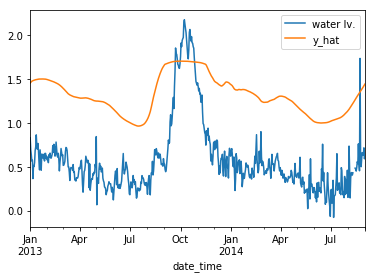

In [99]:

output.plot()